In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import *
from scipy.optimize import minimize

from functions_asset_pricing import *
from functions_parametric_portfolio import *
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# 1. Data clean

In [2]:
# import data
data = pd.read_csv('data.csv')

# datetime
data['date'] = pd.to_datetime(data['date'])

# there is no missing data
print(data.isna().sum().sum())

0


In [3]:
############
# calculate daily return
############
# sort by ticker and date
data = data.sort_values(by=['ticker','date'])

# get one-day lagged last
data = get_char_lag(data=data, stock_name='ticker', date_name='date', var_name='last')

# calculate returns
temp = data.groupby(['date','ticker']).apply(lambda x: (x['last']-x['last_lag'])/x['last_lag'] )
temp = temp.reset_index(drop=False)
temp = temp.rename(columns={0:'ret'})

# merge returns
data = pd.merge(data, temp[['date','ticker','ret']], how='left', on=['date','ticker'])

In [4]:
############
# create monthly dataframe
############
# get monthend date
data['date_m'] = data['date'] + MonthEnd(0)

# get the last trading day of that month
temp = data.groupby(['ticker','date_m'])['date'].max()
temp = temp.reset_index(drop=False)
temp = temp.rename(columns={'date':'date_mt'})

# merge last trading day
data = pd.merge(data, temp, how='left', on=['ticker','date_m'])

# create monthly dataframe
df = data[data['date']==data['date_mt']][['ticker','date','date_m']]
df = df.reset_index(drop=True)

# calculate monthly returns
temp = data[data['ret'].notna()]
temp = temp.groupby(['ticker','date_m']).apply(lambda x: np.prod(1+x['ret'])-1)
temp = temp.reset_index(drop=False)
temp = temp.rename(columns={0:'ret'})

# merge monthly returns
df = pd.merge(df, temp, how='left', on=['ticker','date_m'])

# 2. Stock characteristics

In [5]:
############
# Dollar volume (dolvol)
############
# calcute daily dollar volume
data['dolvol'] = data['last']*data['volume']

# calcute monthly dollar volume

temp = data.groupby(['ticker','date_m'])['dolvol'].sum()
temp = temp.reset_index(drop=False)

# merge monthly dollar volume
df = pd.merge(df, temp, how='left', on=['ticker','date_m'])

############
# CAPM: beta (beta) and iyosyncratic risk (rvar_capm)
############
# create market return as the dolvol-weighted sum of individual stock returns
# this an approximate for market return
temp = df.groupby('date').apply(lambda x: np.sum(x['ret']*x['dolvol']/np.sum(x['dolvol'])) )
temp = temp.reset_index(drop=False)
temp = temp.rename(columns={0:'mkt'})

# merge market return
df = pd.merge(df, temp, how='left', on=['date'])

# riskfree rate=0
df['rf'] = 0

In [6]:
df = get_beta(data=df, stock_name='ticker', date_name='date', market_return='mkt', stock_return='ret', rolling_length=15)

In [7]:
############
# Momentum: reversal (mom1m) and momentum (mom12m)
############
# get lagged monthly return
df = get_char_lag(data=df, stock_name='ticker', date_name='date', var_name='ret')

# rename reversal
df = df.rename(columns={'ret_lag':'mom1m'})

# calculate momentum
df = get_mom12m(data=df,date_name='date',stock_name='ticker',ret_name='ret')

In [8]:
############
# get ranking chars
############
for char in ['dolvol','beta','rvar_capm','mom1m','mom12m']:
    df = get_rank_char(data=df, var_name=char, date_name='date')
    
chars = ['rank_dolvol','rank_beta','rank_rvar_capm','rank_mom1m','rank_mom12m']

In [9]:
df = df[df['beta'].notna()]

# 3. Parametric Portfolio

In [10]:
stock_name = 'ticker'
date_name = 'date_m'
return_name = 'ret'

frequency = 'monthly'

#industry_name = 'ffi49'
rolling_window = 12

gamma = 4

weight_winsorize = False
industry_name = []

chars = ['rank_dolvol','rank_beta','rank_rvar_capm','rank_mom1m','rank_mom12m']

vars_keep = ['dolvol']

In [11]:
gamma = 4
df_gamma4 = BPR_portfolio(df, stock_name, date_name, return_name, frequency, industry_name, rolling_window, gamma, weight_winsorize, chars, vars_keep)

gamma = 6
df_gamma6 = BPR_portfolio(df, stock_name, date_name, return_name, frequency, industry_name, rolling_window, gamma, weight_winsorize, chars, vars_keep)

gamma = 8
df_gamma8 = BPR_portfolio(df, stock_name, date_name, return_name, frequency, industry_name, rolling_window, gamma, weight_winsorize, chars, vars_keep)

# 4. Portfolio performance

In [12]:
chars_name = chars
date_name = 'date_m'
rolling_window = 12

df = df_gamma6
port_chars_gamma6 = get_portfolio_chars(df,chars_name,date_name,rolling_window)

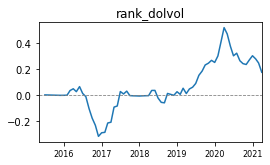

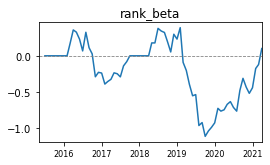

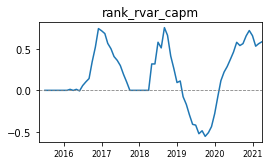

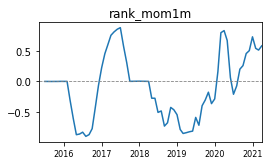

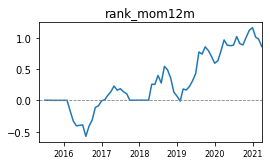

In [13]:
# plot portfolio characteristics
for char in chars:
    fig, ax1 = plt.subplots(figsize=(4,2.2))
    plt.plot(port_chars_gamma6[char].rolling(3).mean())
    ax1.axhline(y=0,color='grey',linewidth=0.8,linestyle='--')
    
    plt.xlim(min(port_chars_gamma6.index),max(port_chars_gamma6.index))
    plt.title(char)
    ax1.xaxis.set_tick_params(labelsize=8)
    plt.show()
    fig.savefig('Figure_port_chars_'+char+'.pdf', format="pdf", bbox_inches='tight', frameon=False)

In [14]:
# port = port_return
date_name = 'date_m'
port_name = 'w_raw_normalize'
benchmark_portfolio_name = '1/N'
benchmark_portfolio = False
chars_name = chars

# create portfolio performance evaluation table
df = df_gamma4
port_column_name = 'gamma=4'
table = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)

df = df_gamma6
port_column_name = 'gamma=6'
table_temp = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

df = df_gamma8
port_column_name = 'gamma=8'
benchmark_portfolio = True
table_temp = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# print tables
print(table)

                      gamma=4  gamma=6  gamma=8    1/N
theta rank_dolvol       0.000    0.000    0.000    NaN
theta rank_beta        -2.202   -2.205   -2.258    NaN
theta rank_rvar_capm    2.537    2.248    1.584    NaN
theta rank_mom1m       -1.129   -1.507   -1.519    NaN
theta rank_mom12m       3.506    3.318    2.778    NaN
|w|*100                 1.190    1.139    1.028  0.527
max w*100               3.505    3.302    2.778    NaN
min w*100              -2.347   -2.178   -1.785    NaN


In [15]:
weight_name = 'w_raw_normalize'
date_name = 'date_m'
stock_name = 'ticker'
 
port_return_gamma4 = get_portfolio(df_gamma4, weight_name, date_name, stock_name, return_name, rolling_window)
port_return_gamma6 = get_portfolio(df_gamma6, weight_name, date_name, stock_name, return_name, rolling_window)
port_return_gamma8 = get_portfolio(df_gamma8, weight_name, date_name, stock_name, return_name, rolling_window)

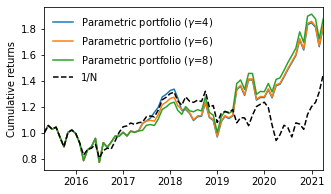

In [16]:
# plot cumulative returns
fig, ax1 = plt.subplots(figsize=(5,3))

plt.plot(port_return_gamma4[['ret_cum']], label='Parametric portfolio ($\gamma$=4)')
plt.plot(port_return_gamma6[['ret_cum']], label='Parametric portfolio ($\gamma$=6)')
plt.plot(port_return_gamma8[['ret_cum']], label='Parametric portfolio ($\gamma$=8)')
plt.plot(port_return_gamma4[['ret_market_cum']], label='1/N', color='black',linestyle='--')

plt.xlim(min(port_return_gamma4.index),max(port_return_gamma4.index) )
plt.ylabel('Cumulative returns')
plt.legend(frameon=False)
plt.show()

# save figures
fig.savefig('Figure_cum_ret.pdf', format="pdf", bbox_inches='tight', frameon=False)

In [17]:
# port = port_return
port_name = 'ret'
benchmark_name = 'ret_market'
rf_name = 'rf'
benchmark_portfolio = False
benchmark_portfolio_name = '1/N'

# create portfolio performance evaluation table
port_return_gamma4['rf'] = 0
port = port_return_gamma4
port_column_name = 'gamma=4'
table = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)

port_return_gamma6['rf'] = 0
port = port_return_gamma6
port_column_name = 'gamma=6'
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

port_return_gamma8['rf'] = 0
port = port_return_gamma8
port_column_name = 'gamma=8'
benchmark_portfolio = True
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# print tables
print(table)

                     gamma=4  gamma=6  gamma=8     1/N
Average returns        0.011    0.011    0.012   0.007
Std. returns           0.069    0.068    0.068   0.057
Sharpe ratio           0.162    0.164    0.171   0.128
Alpha                  0.007    0.007    0.007     NaN
Beta                   0.600    0.598    0.608     NaN
Std. CAPM residuals    0.059    0.058    0.058     NaN
Information ratio      0.060    0.061    0.069     NaN
Observations          72.000   72.000   72.000  72.000


# 5. Extensions: shortsell constraint

In [18]:
# get No-short-sale constrain weights
weight_name = 'w_raw'
date_name = 'date_m'

df = df_gamma4
df_gamma4 = get_weights_short(df, weight_name, date_name)

df = df_gamma6
df_gamma6 = get_weights_short(df, weight_name, date_name)

df = df_gamma8
df_gamma8 = get_weights_short(df, weight_name, date_name)

In [19]:
weight_name = 'w_short_normalize'
date_name = 'date_m'
stock_name = 'ticker'

port_return_gamma4_short = get_portfolio(df_gamma4,weight_name,date_name,stock_name, return_name, rolling_window)
port_return_gamma6_short = get_portfolio(df_gamma6,weight_name,date_name,stock_name, return_name, rolling_window)
port_return_gamma8_short = get_portfolio(df_gamma8,weight_name,date_name,stock_name, return_name, rolling_window)

port_return_gamma4_short = port_return_gamma4_short.rename(columns={'ret':'ret_short','ret_cum':'ret_cum_short'})
port_return_gamma6_short = port_return_gamma6_short.rename(columns={'ret':'ret_short','ret_cum':'ret_cum_short'})
port_return_gamma8_short = port_return_gamma8_short.rename(columns={'ret':'ret_short','ret_cum':'ret_cum_short'})

In [20]:
port_return_gamma4 = pd.merge(port_return_gamma4, port_return_gamma4_short[['ret_short','ret_cum_short']], how='left', left_index=True, right_index=True)
port_return_gamma6 = pd.merge(port_return_gamma6, port_return_gamma6_short[['ret_short','ret_cum_short']], how='left', left_index=True, right_index=True)
port_return_gamma8 = pd.merge(port_return_gamma8, port_return_gamma8_short[['ret_short','ret_cum_short']], how='left', left_index=True, right_index=True)

In [21]:
# port = port_return
date_name = 'date_m'
port_name = 'w_raw_normalize'
benchmark_portfolio_name = '1/N'
benchmark_portfolio = False

# create portfolio performance evaluation table
df = df_gamma4
port_column_name = 'gamma=4'
table = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)

df = df_gamma8
port_column_name = 'gamma=8'
table_temp = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# short
port_name = 'w_short_normalize'
df = df_gamma4
port_column_name = 'gamma=4 (nonshort)'
table_temp = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

df = df_gamma8
port_column_name = 'gamma=8 (nonshort)'
#benchmark_portfolio = True
table_temp = get_weights_properties(df, date_name, port_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name, chars_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# print tables
print(table)

                      gamma=4  gamma=8  gamma=4 (nonshort)  gamma=8 (nonshort)
theta rank_dolvol       0.000    0.000               0.000               0.000
theta rank_beta        -2.202   -2.258              -2.202              -2.258
theta rank_rvar_capm    2.537    1.584               2.537               1.584
theta rank_mom1m       -1.129   -1.519              -1.129              -1.519
theta rank_mom12m       3.506    2.778               3.506               2.778
|w|*100                 1.190    1.028               0.452               0.452
max w*100               3.505    2.778               1.740               1.433
min w*100              -2.347   -1.785               0.106               0.182


In [22]:
# port = port_return
port_name = 'ret'
benchmark_name = 'ret_market'
rf_name = 'rf'
benchmark_portfolio = False
benchmark_portfolio_name = '1/N'

# create portfolio performance evaluation table
port_return_gamma4['rf'] = 0
port = port_return_gamma4
port_column_name = 'gamma=4'
table = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)

port_return_gamma8['rf'] = 0
port = port_return_gamma8
port_column_name = 'gamma=8'
#benchmark_portfolio = True
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# short
port_name = 'ret_short'
port_return_gamma4['rf'] = 0
port = port_return_gamma4
port_column_name = 'gamma=4 (nonshort)'
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

port_return_gamma8['rf'] = 0
port = port_return_gamma8
port_column_name = 'gamma=8 (nonshort)'
#benchmark_portfolio = True
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# print tables
print(table)

                     gamma=4  gamma=8  gamma=4 (nonshort)  gamma=8 (nonshort)
Average returns        0.011    0.012               0.008               0.008
Std. returns           0.069    0.068               0.054               0.054
Sharpe ratio           0.162    0.171               0.145               0.143
Alpha                  0.007    0.007               0.001               0.001
Beta                   0.600    0.608               0.902               0.906
Std. CAPM residuals    0.059    0.058               0.017               0.016
Information ratio      0.060    0.069               0.032               0.027
Observations          72.000   72.000              72.000              72.000


# 5. Extensions: transaction cost 

In [23]:
weight_name = 'w_raw_normalize'
stock_name = 'ticker'
date_name = 'date_m'
me_name = 'dolvol'
port_name = 'ret'

df = df_gamma4
df['dolvol'] = np.log(df['dolvol'])
port = port_return_gamma4
df_gamma4, port_return_gamma4 = get_portfolio_transaction_cost(df, port, weight_name, stock_name, date_name, me_name, port_name)

df = df_gamma6
df['dolvol'] = np.log(df['dolvol'])
port = port_return_gamma6
df_gamma6, port_return_gamma6 = get_portfolio_transaction_cost(df, port, weight_name, stock_name, date_name, me_name, port_name)

df = df_gamma8
df['dolvol'] = np.log(df['dolvol'])
port = port_return_gamma8
df_gamma8, port_return_gamma8 = get_portfolio_transaction_cost(df, port, weight_name, stock_name, date_name, me_name, port_name)

In [24]:
# port = port_return
port_name = 'ret'
benchmark_name = 'ret_market'
rf_name = 'rf'
benchmark_portfolio = False
benchmark_portfolio_name = '1/N'

# create portfolio performance evaluation table
port_return_gamma4['rf'] = 0
port = port_return_gamma4
port_column_name = 'gamma=4'
table = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)

port_return_gamma8['rf'] = 0
port = port_return_gamma8
port_column_name = 'gamma=8'
#benchmark_portfolio = True
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# short
port_name = 'ret_tc'
port_return_gamma4['rf'] = 0
port = port_return_gamma4
port_column_name = 'gamma=4 (with tc.)'
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

port_return_gamma8['rf'] = 0
port = port_return_gamma8
port_column_name = 'gamma=8 (with tc.)'
#benchmark_portfolio = True
table_temp = portfolio_evaluation(port, port_name, benchmark_name, rf_name, port_column_name, benchmark_portfolio, benchmark_portfolio_name)
table = pd.merge(table, table_temp, how='left', left_index=True, right_index=True)

# print tables
print(table)

                     gamma=4  gamma=8  gamma=4 (with tc.)  gamma=8 (with tc.)
Average returns        0.011    0.012               0.003               0.006
Std. returns           0.069    0.068               0.068               0.067
Sharpe ratio           0.162    0.171               0.045               0.084
Alpha                  0.007    0.007              -0.001               0.001
Beta                   0.600    0.608               0.611               0.619
Std. CAPM residuals    0.059    0.058               0.058               0.057
Information ratio      0.060    0.069              -0.067              -0.026
Observations          72.000   72.000              72.000              72.000
